In [18]:
%matplotlib inline
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import DataConversionWarning
from sklearn.metrics import accuracy_score

warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [3]:
# Import data
test_features = pd.read_csv('test_features.csv')
train_features = pd.read_csv('train_features.csv')
train_labels = pd.read_csv('train_labels.csv')

# assign to train, test, and submission
X_train = train_features.drop(columns='id')
X_test = test_features.drop(columns='id')
y_train = train_labels.drop(columns='id')
submission = test_features[['id']]

X_train.shape, X_test.shape, y_train.shape

((59400, 39), (14358, 39), (59400, 1))

In [7]:
# Split training data into train, validate. Make the validation set the same shape of the test set.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=len(X_test), stratify=y_train, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((45042, 39), (14358, 39), (45042, 1), (14358, 1))

### Data cleaning, feature engineering, and categorical encoding

In [8]:
def wrangle(X):
    # Create copy of dataframe to avoid copy warning
    X = X.copy()
    
    # Some features have missing data showing as 0 that need to be changed to nan
    X['gps_height'] = X['gps_height'].replace(0.0, np.nan)
    X['longitude'] = X['longitude'].replace(0.0, np.nan)
    X['latitude'] = X['latitude'].replace(0.0, np.nan)
    X['construction_year'] = X['construction_year'].replace(0.0, np.nan)
    X['population'] = X['population'].replace(0.0, np.nan)
    X['amount_tsh'] = X['amount_tsh'].replace(0.0, np.nan)
    
    # gps_height: replace nan values with the mean of the smallest geographical region possible
    # Excluding subvillage due to missing values
    X['gps_height'].fillna(X.groupby(['ward'])['gps_height'].transform('mean'), inplace=True)
    X['gps_height'].fillna(X.groupby(['district_code'])['gps_height'].transform('mean'), inplace=True)
    X['gps_height'].fillna(X.groupby(['region_code'])['gps_height'].transform('mean'), inplace=True)
    X['gps_height'].fillna(X['gps_height'].mean(), inplace=True)
    
    # longitude: replace nan values with the mean of the smallest geographical region possible
    # Excluding subvillage due to missing values
    X['longitude'].fillna(X.groupby(['ward'])['longitude'].transform('mean'), inplace=True)
    X['longitude'].fillna(X.groupby(['district_code'])['longitude'].transform('mean'), inplace=True)
    X['longitude'].fillna(X.groupby(['region_code'])['longitude'].transform('mean'), inplace=True)
    X['longitude'].fillna(X['longitude'].mean(), inplace=True)
    
    # latitude: replace nan values with the mean of the smallest geographical region possible
    # Excluding subvillage due to missing values
    X['latitude'].fillna(X.groupby(['ward'])['latitude'].transform('mean'), inplace=True)
    X['latitude'].fillna(X.groupby(['district_code'])['latitude'].transform('mean'), inplace=True)
    X['latitude'].fillna(X.groupby(['region_code'])['latitude'].transform('mean'), inplace=True)
    X['latitude'].fillna(X['latitude'].mean(), inplace=True)
    
    # population: replace nan values with the mean of the smallest geographical region possible
    # Excluding subvillage due to missing values
    X['population'].fillna(X.groupby(['ward'])['population'].transform('median'), inplace=True)
    X['population'].fillna(X.groupby(['district_code'])['population'].transform('median'), inplace=True)
    X['population'].fillna(X.groupby(['region_code'])['population'].transform('median'), inplace=True)
    X['population'].fillna(X['population'].median(), inplace=True)
    
    # population: replace nan values with the mean of the smallest geographical region possible
    # Excluding subvillage due to missing values
    X['amount_tsh'].fillna(X.groupby(['ward'])['amount_tsh'].transform('median'), inplace=True)
    X['amount_tsh'].fillna(X.groupby(['district_code'])['amount_tsh'].transform('median'), inplace=True)
    X['amount_tsh'].fillna(X.groupby(['region_code'])['amount_tsh'].transform('median'), inplace=True)
    X['amount_tsh'].fillna(X['amount_tsh'].median(), inplace=True)
    
    # construction_year: replace nan values with the mean of the smallest geographical region possible
    # Excluding subvillage due to missing values
    X['construction_year'].fillna(X.groupby(['ward'])['construction_year'].transform('median'), inplace=True)
    X['construction_year'].fillna(X.groupby(['district_code'])['construction_year'].transform('median'), inplace=True)
    X['construction_year'].fillna(X.groupby(['region_code'])['construction_year'].transform('median'), inplace=True)
    X['construction_year'].fillna(X['construction_year'].median(), inplace=True)
    
    # Convert date to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract datetime data
    X['year_recorded'] = X['date_recorded'].dt.year
    
    # Drop duplicate or unnecessary features
    X = X.drop(columns=['recorded_by', 'quantity_group', 'date_recorded', 'wpt_name', 'num_private', 'subvillage',
                       'region_code', 'district_code', 'management_group', 'extraction_type_group', 'extraction_type_class',
                       'scheme_name', 'payment', 'water_quality', 'source_type', 'source_class', 'waterpoint_type_group',
                       'ward', 'public_meeting', 'permit'])
    
    # Several categorical features have values showing as '0'
    # Replace '0' with nan
    categoricals = X.select_dtypes(exclude='number').columns.tolist()
    X[categoricals] = X[categoricals].replace('0', np.nan)
    
    # Convert to lowercase to collapse duplicates
    X['waterpoint_type'] = X['waterpoint_type'].str.lower()
    X['funder'] = X['funder'].str.lower()
    X['basin'] = X['basin'].str.lower()
    X['region'] = X['region'].str.lower()
    X['source'] = X['source'].str.lower()
    X['lga'] = X['lga'].str.lower()
    X['management'] = X['management'].str.lower()
    X['quantity'] = X['quantity'].str.lower()
    X['quality_group'] = X['quality_group'].str.lower()
    X['payment_type'] = X['payment_type'].str.lower()
    X['extraction_type'] = X['extraction_type'].str.lower()
    
    # Replace nan values with 'other'
    X["funder"].fillna("other", inplace=True)
    X["scheme_management"].fillna("other", inplace=True)
    X["installer"].fillna("other", inplace=True)
    
    X = X.replace(np.nan, 'other')
    
    return X

In [10]:
def feature_eng(X):
    X = X.copy()
    
    # Engineered features from data exploration and cleaning notebook
    X['amount_tsh_above_1000'] = X['amount_tsh'] > 1000
    X['water_quality_good_and_seasonal'] = (X['quality_group'] == 'good') & (X['quantity'] == 'seasonal')
    X['water_quality_good_and_dry'] = (X['quality_group'] == 'good') & (X['quantity'] == 'dry')
    X['water_quality_good_and_insufficient'] = (X['quality_group'] == 'good') & (X['quantity'] == 'insufficient')
    X['water_quality_good_and_enough'] = (X['quality_group'] == 'good') & (X['quantity'] == 'enough')
    X['water_quality_good'] = X['quality_group'] == 'good'
    X['age'] = 2019 - X['construction_year']
    X['years_since_inspection'] = 2019 - X['year_recorded']
    
    return X

In [13]:
def encode(X_train, X_val, X_test):
    X_train = X_train.copy()
    X_val = X_val.copy()
    X_test = X_test.copy()
    encoder = ce.OrdinalEncoder()
    X_train = encoder.fit_transform(X_train)
    X_val = encoder.transform(X_val)
    X_test = encoder.transform(X_test)
    
    return X_train, X_val, X_test

In [14]:
# run wrangle function
X_train = wrangle(X_train)
X_val = wrangle(X_val)
X_test = wrangle(X_test)

X_train.shape, X_val.shape, X_test.shape

((45042, 20), (14358, 20), (14358, 20))

In [15]:
# run feature_eng function
X_train = feature_eng(X_train)
X_val = feature_eng(X_val)
X_test = feature_eng(X_test)

X_train.shape, X_val.shape, X_test.shape

((45042, 28), (14358, 28), (14358, 28))

In [16]:
# run encode function
X_train, X_val, X_test = encode(X_train, X_val, X_test)

X_train.shape, X_val.shape, X_test.shape

((45042, 28), (14358, 28), (14358, 28))

### Run model

In [19]:
# Set model params
model = RandomForestClassifier(criterion='entropy', max_features=4, n_estimators=251, n_jobs=-1, random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Make Predictions
y_pred = model.predict(X_val)

# Check score
score = accuracy_score(y_val, y_pred)
score

0.8076333751218833

### Plot feature importances

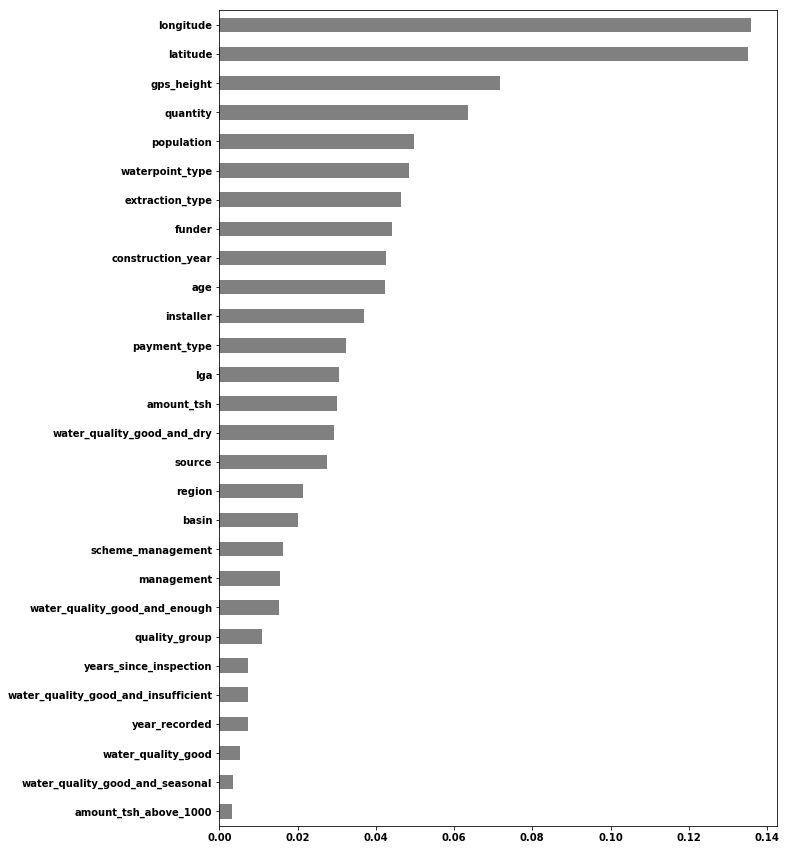

In [22]:
importances = pd.Series(model.feature_importances_, X_train.columns)
n = len(X_train.columns)
top_n = importances.sort_values()[-n:]
plt.figure(figsize=(10, 15))
top_n.plot.barh(color='gray');

### Permutation importances

In [27]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(model.base, scoring='accuracy', cv='prefit', random_state=42)

permuter.fit(X_val.values, y_val)

ImportError: cannot import name 'RandomizedLogisticRegression' from 'sklearn.linear_model' (C:\Users\theta\Anaconda3\envs\lambda\lib\site-packages\sklearn\linear_model\__init__.py)